In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (16, 10)

from torchvision.utils import make_grid , save_image


def show_gen(generated, label=False, path='generated.png', title = 'synthesized'):
    plt.figure(figsize=(50,50))
    plt.axis("off")
    # plt.title("Images ")
    if label:
        plt.imshow(np.transpose(make_grid(generated, nrow=10, padding=2,    normalize=True).cpu(),(1,2,0)), cmap='hot')
        plt.title(title)
    else:
        # plt.imshow(np.transpose(make_grid(generated, nrow=10, padding=2,    normalize=True).cpu(),(3,2,1,0)), cmap='jet')
        plt.imshow(np.transpose(make_grid(generated, nrow=10, padding=2,    normalize=True).cpu(), (1, 2, 0)), cmap='jet')

        plt.title(title)
        # save_image(make_grid(generated,nrow=10, padding=2,    normalize=True).cpu(),fp=path)
        
import sys
sys.argv=['']
del sys

In [58]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import util.util as util

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = False  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.


## train options
# opt.name = 'cmr_test_210719'
# opt.name = 'cmr_test_hinge_210720'
# opt.name = 'cmr_test_original_cut_210721'
# opt.name = 'sim2real_default_cut_210907'
opt.name = 'sim2real_default_cut_rotated_210909'

opt.epoch = '50'
opt.dataset_mode = 'cmr'
opt.model = 'cut'
opt.nce_idt = True
opt.amp = False
opt.direction = 'AtoB'
# opt.direction = 'BtoA'
opt.lambda_identity = 0.5
# opt.image_dir_A = '/data/sina/dataset/seb/SA_files_processed/'
# opt.image_dir_B = '/data/sina/dataset/seb/mms2_processed/Philips/'
# opt.image_dir_A = '/data/sina/dataset/sim2real/sim_phases_train/'
# opt.image_dir_B = '/data/sina/dataset/seb/mms2_processed/Philips/'

opt.image_dir_A = '/data/sina/dataset/sim2real/sim_phases_train_rotated'
opt.image_dir_B = '/data/sina/dataset/sim2real/mms2_processed/Philips/'

opt.max_dataset_size = 5850 
opt.output_nc =  1 
opt.input_nc = 1 
opt.batch_size = 1
opt.num_patches = 16 

opt.display_freq = 50
opt.update_html_freq = 50
opt.save_epoch_freq = 10
opt.evaluation_freq = 500
# opt.normG = 'batch'
# opt.normD = 'batch'
# opt.netD = 'n_layers'   # with the basic discriminator i see GAN artifacts in the translated images and that might be a sign of the fact that the discriminator gets trained faster
# opt.netD = 'multi_scale'
# opt.n_layers_D = 4
opt.n_epochs  = 50
opt.n_epochs_decay = 50
opt.log_file = opt.checkpoints_dir + '/' + opt.name +  '/loss_log.txt'
opt.loss_freq = 1000



----------------- Options ---------------
                 CUT_mode: CUT                           
                      amp: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: placeholder                   
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
               easy_label: experiment_name               
                    epoch: latest                        
                     eval: False                         
        flip_equivariance: False                         
                  gpu_ids: 3                             
              image_dir_A: /data/sina/datasets/seb/SA_files_processed/
              image_dir_B: /data/sina/dataset/seb/mms2_processed/Philips/
 

In [59]:
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
train_dataset = create_dataset(util.copyconf(opt, phase="train"))
model = create_model(opt)      # create a model given opt.model and other options
# create a webpage for viewing the results
web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch))  # define the website directory
print('creating web directory', web_dir)
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))


dataset [CmrDataset] was created
dataset [CmrDataset] was created
model [CUTModel] was created
creating web directory ./results/sim2real_default_cut_rotated_210909/test_50


In [60]:
opt.num_test = 8
generated = []

for i, data in enumerate(dataset):
    if i == 0:
        model.data_dependent_initialize(data)
        model.setup(opt)               # regular setup: load and print networks; create schedulers
        model.parallelize()
        if opt.eval:
            model.eval()
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    generated.append(visuals)
    img_path = model.get_image_paths()     # get image paths
    if i % 5 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... %s' % (i, img_path))
    save_images(webpage, visuals, img_path, width=opt.display_winsize)
webpage.save()  # save the HTML

loading the model from ./checkpoints/sim2real_default_cut_rotated_210909/50_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.366 M
-----------------------------------------------
processing (0000)-th image... ['/data/sina/dataset/sim2real/sim_phases_train_rotated/Image/sim_subject_55.nii.gz']
processing (0005)-th image... ['/data/sina/dataset/sim2real/sim_phases_train_rotated/Image/sim_subject_39.nii.gz']


In [61]:
real_A = []
real_B = []
fake_B = []
for i in range(len(generated)):
    real_A.append(generated[i]['real_A'].squeeze(dim=0))
    real_B.append(generated[i]['real_B'].squeeze(dim=0))
    fake_B.append(generated[i]['fake_B'].squeeze(dim=0))

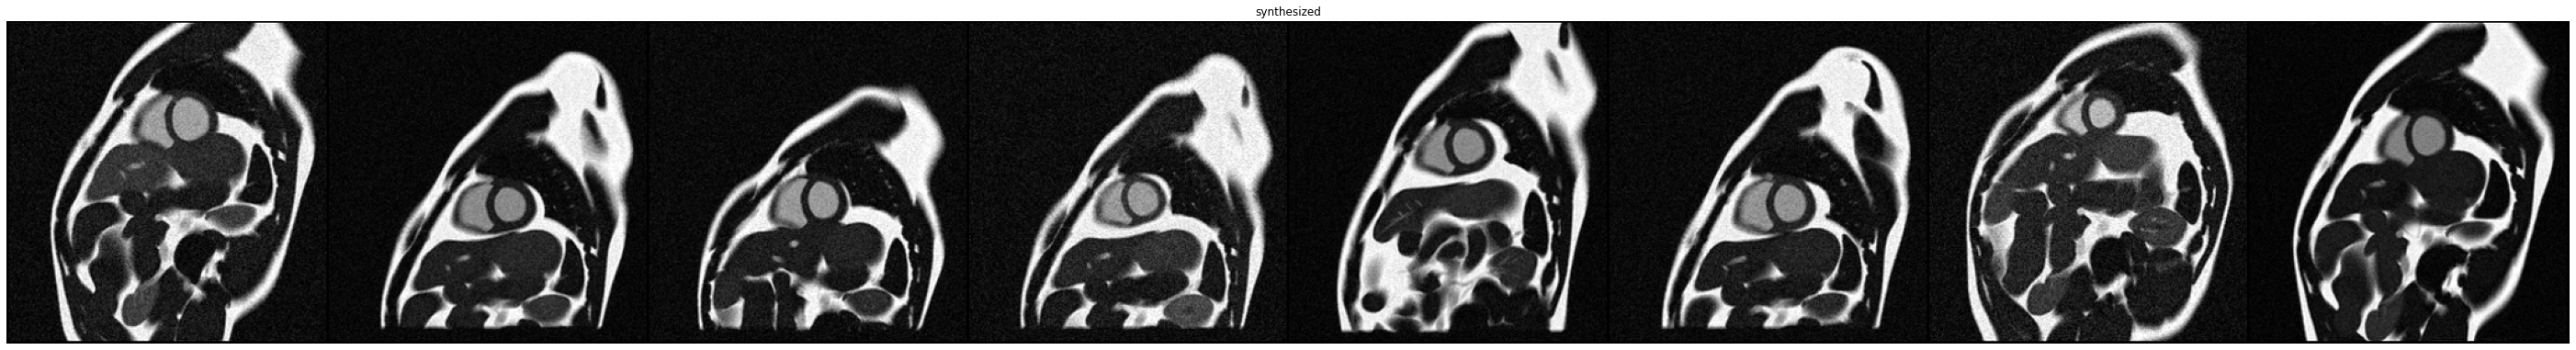

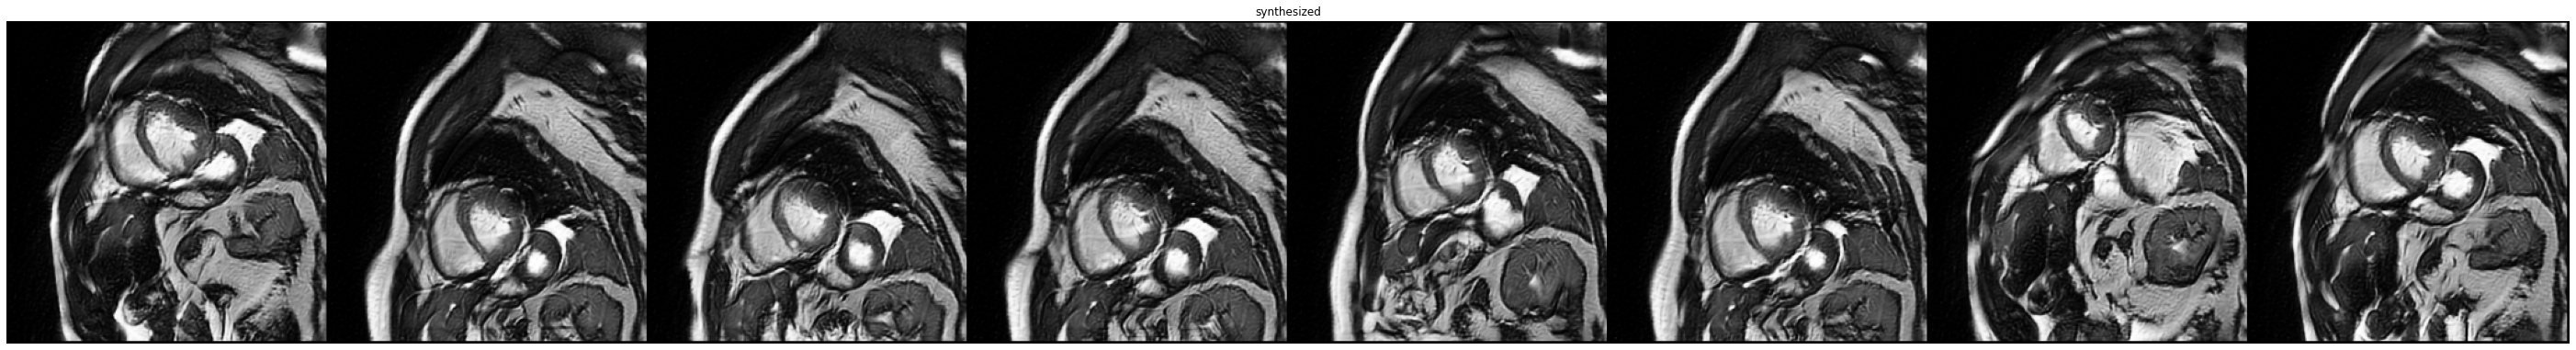

In [62]:
show_gen(real_A)
# show_gen(real_B)
show_gen(fake_B)

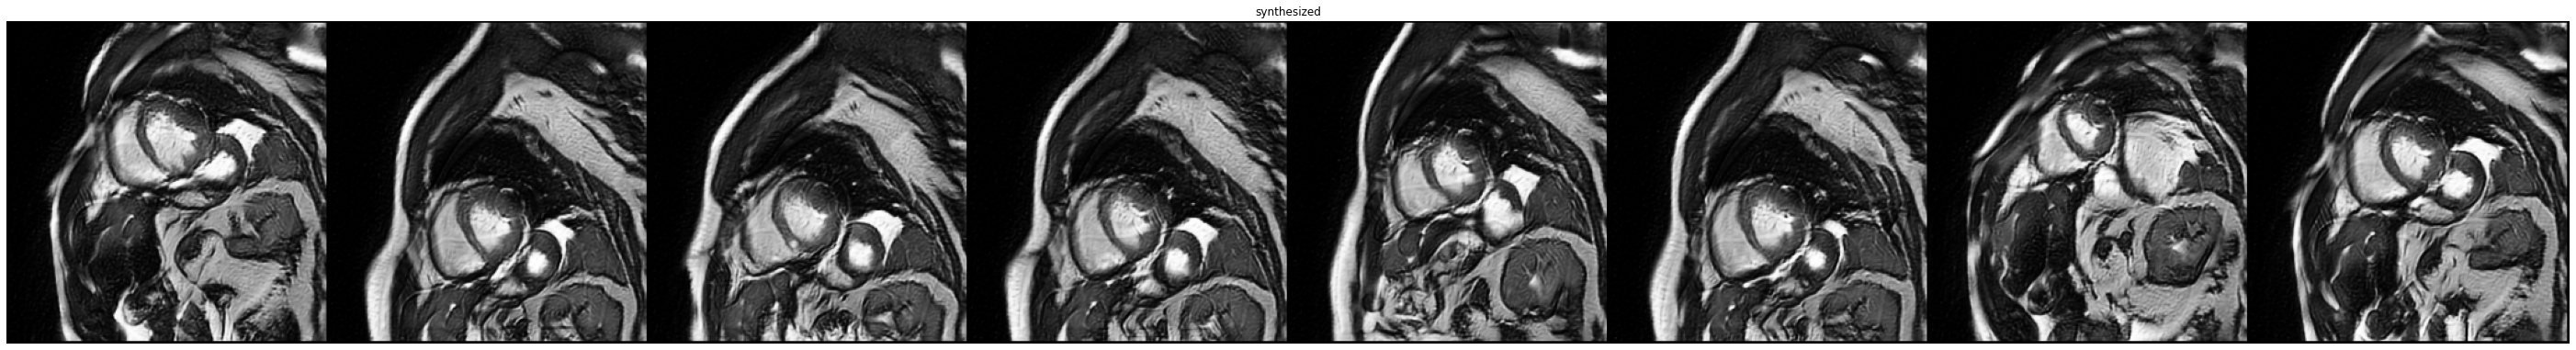

In [63]:
show_gen(fake_B)

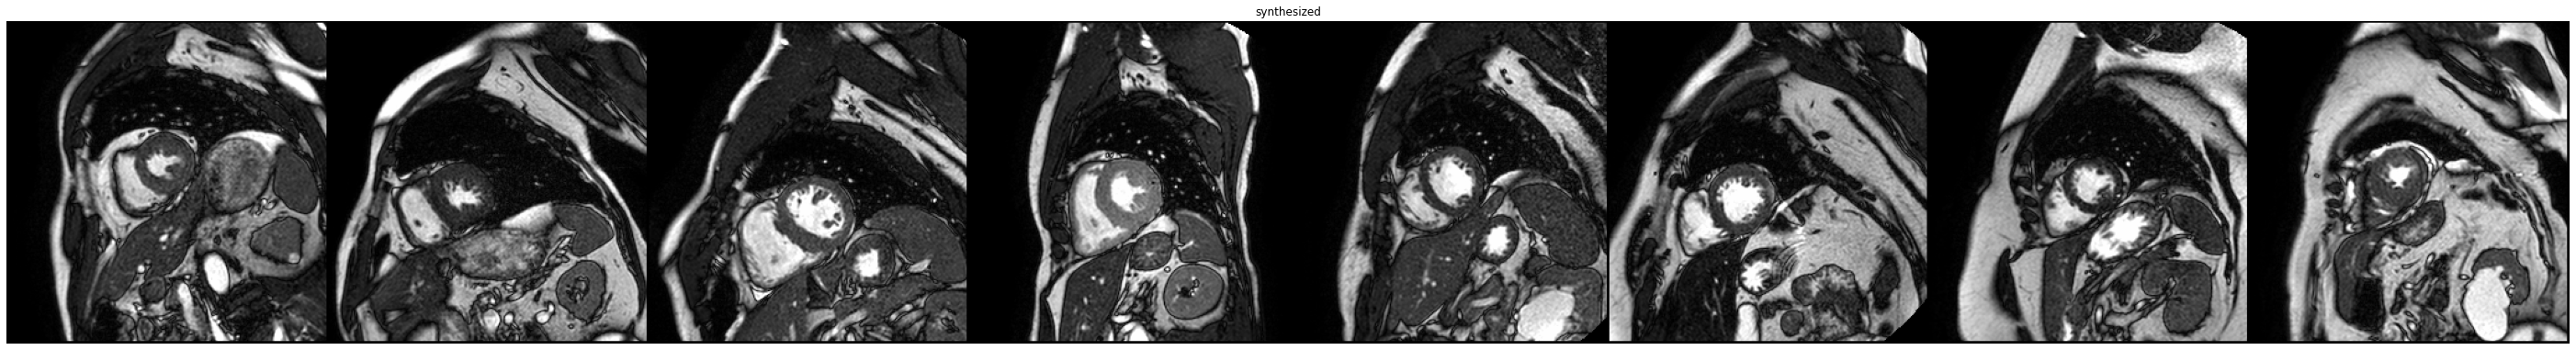

In [64]:
show_gen(real_B)